In [303]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2 
import os 
import random

# Average 필터 사용시 속도 개선을 위해 just in compiler 사용.
from numba import njit

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea']

def load_data(categories):
    # gpu 사용을 위해 코랩에서 진행함.
    path = os.getcwd()+"/drive/MyDrive/colab"
    
    images = []
    labels = []

    for idx, category in enumerate(categories):
        category_path = os.path.join(path, category)
        # 입력 받은 클래스 이름의 폴더가 있으면 내부의 사진들을 읽어온다. 
        if os.path.isdir(category_path):
            for image_name in os.listdir(category_path):
                image_path = os.path.join(category_path, image_name)
                
                # 사진 읽기 (외부 라이브러리 사용)
                image = cv2.imread(image_path)
                
                # opencv는 bgr컬러를 사용하고 pyplot은 rgb를 사용하기 때문에 
                # 색공간을 바꿔준다. 
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                
                # 이미지 크기 조정
                image = cv2.resize(image, (150, 150))
                
                # 이미지 타입 변경 (floa32 사용)
                image = image.astype('float32')

                images.append(image)
                labels.append(idx)

    # 이미지와 라벨을 numpy 배열로 변환
    images = np.asarray(images)
    labels = np.asarray(labels, dtype='int32')

    return (images, labels)

# 원본데이터 
raw_data = load_data(class_names)


In [304]:
# 정규화 함수 
def normalize_data(data):
    images, labels = data
    # 이미지 BGR 최댓값이 255이므로 255로 나누어 정규화 시킨다.
    images_normalized = images / 255.0
    return (images_normalized, labels)

normalized_data = normalize_data(raw_data)

In [305]:
@njit
def apply_padding(image, pad_size):
    # 필터와 이미지 컨볼루션 시 이미지 사이즈가 줄어드는 것을 막기 위해 원본이미지 크기를 늘린다.
    padded_image = np.zeros((image.shape[0] + pad_size * 2, image.shape[1] + pad_size * 2, image.shape[2]))
    padded_image[pad_size:pad_size+image.shape[0], pad_size:pad_size+image.shape[1], :] = image
    return padded_image

# 3중 for문을 쓰기 때문에 매우 느리다. 동적 컴파일러로 속도를 개선한다. 
@njit
def apply_average_filter_1time(image, filter_size=3):
    # 패딩 후 컨볼루션 
    pad_size = filter_size // 2
    padded_image = apply_padding(image, pad_size)
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                # 평균 필터이기 때문에 컨볼루션 대신 np.mean으로 평균 취한다.
                filtered_image[i, j, k] = np.mean(padded_image[i:i+filter_size, j:j+filter_size, k])

    return filtered_image

def apply_average_filter(images, filter_size=3):
    filtered_images = []
    
    for image in images:
        filtered_image = apply_average_filter_1time(image, filter_size)
        filtered_images.append(filtered_image)
    
    return np.array(filtered_images)

normalized_images, labels = normalized_data
# 이미지만 분리하여 평균필터를 통과시킨다.
filtered_images = apply_average_filter(normalized_images)

filtered_data = (filtered_images, labels)


In [306]:
def flip_horizontal(image):
    # 좌우 반전
    return np.flip(image, axis=1)

def flip_vertical(image):
    # 상하반전 
    return np.flip(image, axis=0)

def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []

    for i, image in enumerate(images):
        original_image = image
        horizontal_flipped = flip_horizontal(image)
        vertical_flipped = flip_vertical(image)

        augmented_images.extend([original_image, horizontal_flipped, vertical_flipped])
        augmented_labels.extend([labels[i], labels[i], labels[i]])

    return np.array(augmented_images), np.array(augmented_labels)

X_train, Y_train = augment_images(filtered_images,labels)



In [307]:
def shuffle_data(images, labels, seed=None):
    # 시드값을 주지 않은경우 랜덤으로 섞는다. 
    if seed is not None:
        np.random.seed(seed)
    
    # arange로 생성한 배열을 인덱스로 사용한다. 
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]
    
    return shuffled_images, shuffled_labels

X_train, Y_train = shuffle_data(X_train, Y_train)

shuffled_train_data = (X_train, Y_train)

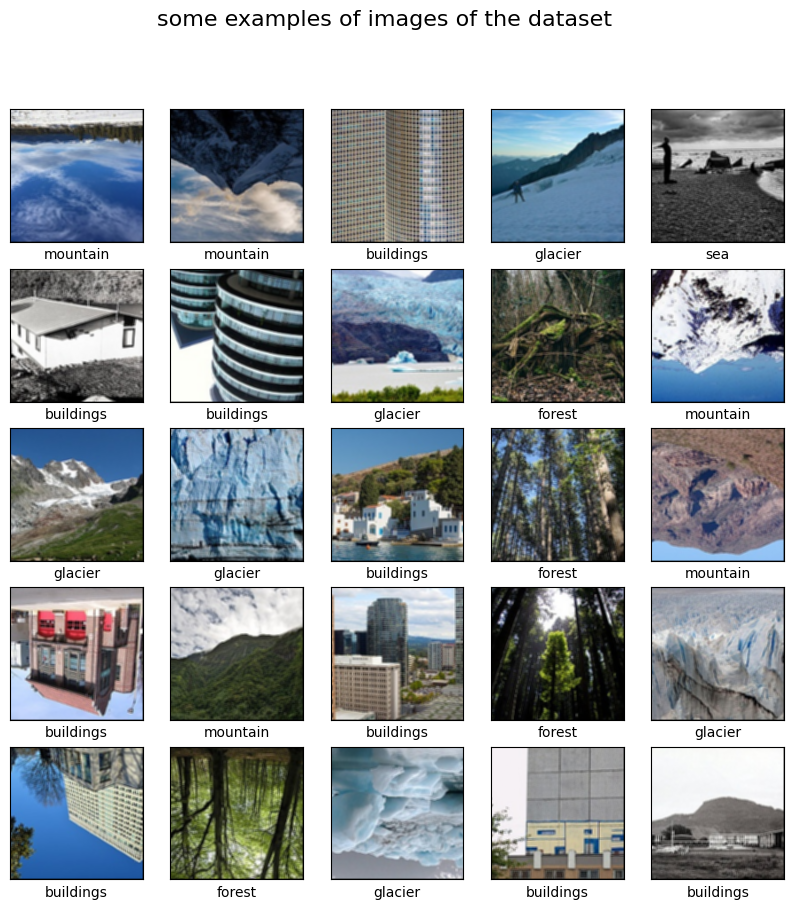

In [308]:
def display_examples(class_names, images, labels):
    # 특정 사진을 골라 출력한다. 
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("some examples of images of the dataset", fontsize = 16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i],cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()    
    
display_examples(class_names,X_train,Y_train)


In [309]:

from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization,Activation,LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

with tf.device('/gpu:0'):
  #GPU 사용한다.
  model = Sequential()
  model._name = "Sangho_CNN"
  model.add(Conv2D(256, kernel_size=(9, 9), input_shape=(150, 150, 3)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPool2D(pool_size=(5,5)))

  model.add(Conv2D(512, (7, 7)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPool2D(pool_size=(3,3)))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(5, activation='softmax'))

  # Adam 옵티마이저 객체 생성 및 학습률 설정
  adam_optimizer = Adam(learning_rate=1e-4)

  # 모델 컴파일에 옵티마이저 객체 전달
  model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
  model.summary()

  checkpoint_filepath = 'best_model.h5'
  # val_accuracy가 최대일 때 모델을 저장하기 위해 콜백 메서드를 정의한다. 
  model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)




Model: "Sangho_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 142, 142, 256)     62464     
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 142, 142, 256)     0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 28, 28, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 22, 22, 512)       6423040   
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 22, 22, 512)       0         
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 7, 7, 512)        0         
 g2D)                                                   

# 새 섹션

In [310]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=128,callbacks=model_checkpoint_callback,validation_split = 0.2)

Epoch 1/50
4/4 [==============================] - 3s 319ms/step - loss: 1.6015 - accuracy: 0.2438 - val_loss: 1.5939 - val_accuracy: 0.2583
Epoch 2/50
4/4 [==============================] - 1s 238ms/step - loss: 1.4481 - accuracy: 0.3875 - val_loss: 1.3345 - val_accuracy: 0.4250
Epoch 3/50
4/4 [==============================] - 1s 238ms/step - loss: 1.3057 - accuracy: 0.4667 - val_loss: 1.2658 - val_accuracy: 0.4667
Epoch 4/50
4/4 [==============================] - 0s 106ms/step - loss: 1.2422 - accuracy: 0.4812 - val_loss: 1.3652 - val_accuracy: 0.4000
Epoch 5/50
4/4 [==============================] - 1s 239ms/step - loss: 1.2026 - accuracy: 0.5125 - val_loss: 1.1837 - val_accuracy: 0.5167
Epoch 6/50
4/4 [==============================] - 0s 104ms/step - loss: 1.1003 - accuracy: 0.5458 - val_loss: 1.1483 - val_accuracy: 0.4833
Epoch 7/50
4/4 [==============================] - 4s 1s/step - loss: 1.0662 - accuracy: 0.5604 - val_loss: 1.2253 - val_accuracy: 0.5250
Epoch 8/50
4/4 [=======

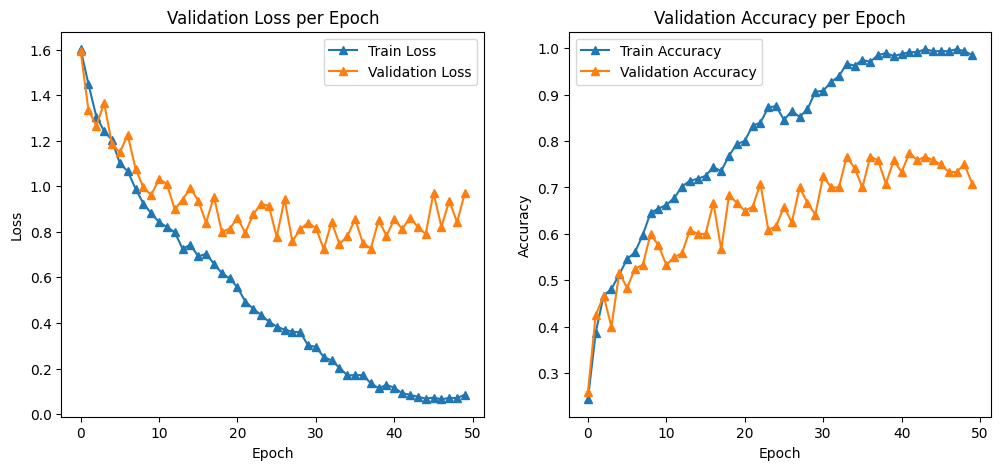

In [311]:
# epoch마다 val_loss와 val_acc의 변화량 그래프
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 옵션 값을 설정하셨으니 그래프 이외 주석은 빼도됩니다.
ax1.plot(history.history['loss'], label='Train Loss',marker='^')
ax1.plot(history.history['val_loss'], label='Validation Loss',marker='^')
ax1.set_title('Validation Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train Accuracy',marker='^')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='^')
ax2.set_title('Validation Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()
